#  Предобработка текстов

## Подключаем часть необходимых модулей для предобработки документов

In [1]:
import pandas as pd     #для предобработки
import numpy as np      #линал и фиксирование случайных величин
import os               #взаймодействие с файлами
import requests         #для скачивания
#работа с pdf файлами
import pdfminer
import PyPDF2
import io
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage
from pdfminer.layout import LAParams

#корпус стоп слов
from nltk.corpus import stopwords
#загружаем
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

import re #для написания регулярных выражений

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dubovitsky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### В папке '/arxiv.org/ находятся excel таблицы с ссылками на статьи. Скачаем 100 статей по каждой теме для тренировочного набора.

In [6]:
num_texts = 100 #количество файлов для скачивания для train 
#t = ['cond-mat.quant-gas.xlsx']
#for filename in t:#os.listdir(os.getcwd() + '/arxiv.org'):
for filename in os.listdir(os.getcwd() + '/arxiv.org'):
    print(filename)
    df = pd.read_excel(os.getcwd() + '/arxiv.org/'+filename ,encoding = "ISO-8859-1")
    folder = filename.replace('.xlsx', '')
    if not os.path.isdir(folder):
        os.makedirs(folder)
    for i in range(len(df.url)):
        print(i)
        if(i==num_texts):
            break
        url=df.url[i].replace('abs', 'pdf')
        r = requests.get(url, stream=True)
        with open('/home/dubovitsky/Диплом/'+ folder + '/' + str(i) + '.pdf', 'wb') as f:
            f.write(r.content)

math.AP.xlsx
0


SSLError: HTTPSConnectionPool(host='arxiv.org', port=443): Max retries exceeded with url: /pdf/1412.0117 (Caused by SSLError(SSLError("bad handshake: SysCallError(104, 'ECONNRESET')")))

### Необходимо проверить целостность скачанных файлов. Для этого проверяем размер файлов.

In [2]:
for filename in os.listdir(os.getcwd() + '/arxiv.org'):
    print(filename)
    df = pd.read_excel(os.getcwd() + '/arxiv.org/' + filename ,encoding = "ISO-8859-1")
    folder = filename.replace('.xlsx', '')
    c = 0
    for i in range(0,100):
        statinfo = os.stat('/home/dubovitsky/Диплом/' + folder)
        if statinfo.st_size < 2000:
            c +=1
    print(c)

math.AP.xlsx
0
nucl-ex.xlsx
0
cond-mat.stat-mech.xlsx
0
math.DG.xlsx
0
math.AG.xlsx
0
cond-mat.quant-gas.xlsx
0
astro-ph.EP.xlsx
0
cs.IT.xlsx
0
physics.optics.xlsx
0
quant-ph.xlsx
0
cs.AI.xlsx
0
math-ph.xlsx
0
astro-ph.SR.xlsx
0
math.CO.xlsx
0
nucl-th.xlsx
0


### Определеям функции, которые будут необходимы в извлечении текста из pdf файлов.

In [2]:
laparams = LAParams()

def extract_text_from_pdf(pdf_path):
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle, laparams=laparams)
    page_interpreter = PDFPageInterpreter(resource_manager, converter)
    with open(pdf_path, 'rb') as fh:
        for page in PDFPage.get_pages(fh, 
                                      caching=True,
                                      check_extractable=True):
            page_interpreter.process_page(page)
        text = fake_file_handle.getvalue()
    # close open handles
    converter.close()
    fake_file_handle.close()
    if text:
        return text
import nltk
import string
from nltk.corpus import stopwords
#nltk.download('punkt')

def tokenize_me(file_text):
    #firstly let's apply nltk tokenization
    tokens = nltk.word_tokenize(file_text)
 
    #let's delete punctuation symbols
    tokens = [i for i in tokens if ( i not in string.punctuation )]
 
    #deleting stop_words
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if ( i not in stop_words )]
 
    #cleaning words
    tokens = [i.replace("«", "").replace("»", "") for i in tokens]
 
    return tokens

### Извлекаем из pdf файлов текст и выбрасываем стоп слова. 

In [29]:
for filename in os.listdir(os.getcwd() + '/arxiv.org'):
    print(filename)
    df = pd.read_excel(os.getcwd() + '/arxiv.org/' + filename ,encoding = "ISO-8859-1")
    folder = filename.replace('.xlsx', '')
    for i in range(98,100):
        print(i)
        k = extract_text_from_pdf(folder + '/' + str(i) + '.pdf')
        #.replace('\xa0', ' ')
        tokens = tokenize_me(k.lower())
        #k = k.replace('-\xad', ' ')
        #k = k.replace('\t\r',' ')
        #k = k.replace('\x0c',' ')
        #k = k.replace('\n','')
        #k = k.lower()
        #k = re.sub(r'[^a-z]', ' ', e)
        #text_split = k.split(' ')
        k = []
        for t in tokens:
            if len(t)>2:         # не учитываем слова длинной <=2
                k.append(t)
        tokenized_words = [word for word in k if word not in stop_words]
        #print(k)
        if not os.path.isdir(folder + '/txt'):
            os.makedirs(folder + '/txt')
        with open('/home/dubovitsky/Диплом/'+ folder + '/txt' + '/' + str(i) + '.txt', 'w') as f:
            for item in tokenized_words:
                f.write("%s\n" % item)

nucl-th.xlsx
98
99


### Теперь у нас есть для каждого pdf файла есть файл формата txt, который содержит весь текст этого pdf, за исключением стоп слов. Но даже после удаления стоп слов некоторые файлы содержат больше 10000 слов.

In [6]:
def count_lines(filename, chunk_size=1<<13):
    with open(filename) as file:
        return sum(chunk.count('\n')
                   for chunk in iter(lambda: file.read(chunk_size), ''))

In [12]:
for i in range(0,100):
    t = count_lines("cs.AI/txt/" + str(i) + ".txt")    
    if(t>10000):
        print("номер статьи: " + str(i) + " количество слов: " + str(t))
    

номер статьи: 18 количество слов: 10426
номер статьи: 26 количество слов: 14025
номер статьи: 37 количество слов: 10081
номер статьи: 55 количество слов: 11759


### На это есть несколько причин: 
1) В первичной обработке не были применены стэминг и лемматизация. Теперь необходимо обработать каждый txt файл.

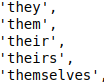

In [14]:
from IPython.display import Image
Image("same_but_different.png")

2) Также в файлах присутствует шум из-за переноса текста из pdf в txt. А именно: шрифты cid.

In [16]:
Image("noise_2.png")

3) Числа и прочее:

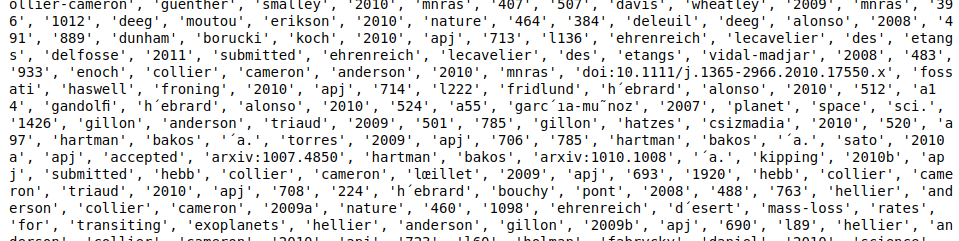

In [17]:
Image("noise_1.png")

In [20]:
f = open('cs.AI/txt/0.txt', 'r')
x = f.read().splitlines()
f.close()
print(x)

['benders', 'decomposition', 'design', 'hub', 'shuttle', 'public', 'transit', 'system', 'arthur', 'mah´eo', 'philip', 'kilby', 'australian', 'national', 'university', 'acton', 'act', '2601', 'australia', 'data61', 'tower', 'london', 'circuit', 'canberra', 'city', 'act', '2601', 'australia', 'arthur.maheo', 'philip.kilby', 'nicta.com.au', 'pascal', 'van', 'hentenryck', 'university', 'michigan', 'industrial', 'operations', 'engineering', '1205', 'beal', 'avenue', 'ann', 'arbor', '48109.', 'pvanhent', 'umich.edu', 'busplus', 'project', 'aims', 'improving', 'oﬀ-peak', 'hours', 'public', 'transit', 'service', 'canberra', 'australia', 'address', 'diﬃculty', 'covering', 'large', 'geographic', 'area', 'busplus', 'proposes', 'hub', 'shuttle', 'model', 'consisting', 'combination', 'high-frequency', 'bus', 'routes', 'key', 'hubs', 'large', 'number', 'shuttles', 'bring', 'passengers', 'origin', 'closest', 'hub', 'take', 'last', 'bus', 'stop', 'destination', 'paper', 'focuses', 'design', 'bus', 'ne

In [21]:
txt = []
for i in x:
    if i.isalpha():
        txt.append(i)

Разница в количестве слов, если уберем слова, которые содержат не только буквенные символы.

In [44]:
print(len(x)-len(txt))

723


## Лемматизация и стэмминг на примере одного документа.

In [18]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/dubovitsky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [49]:
for i in txt:
    print(i)

benders
decomposition
design
hub
shuttle
public
transit
system
arthur
philip
kilby
australian
national
university
acton
act
australia
tower
london
circuit
canberra
city
act
australia
pascal
van
hentenryck
university
michigan
industrial
operations
engineering
beal
avenue
ann
arbor
pvanhent
busplus
project
aims
improving
hours
public
transit
service
canberra
australia
address
diﬃculty
covering
large
geographic
area
busplus
proposes
hub
shuttle
model
consisting
combination
bus
routes
key
hubs
large
number
shuttles
bring
passengers
origin
closest
hub
take
last
bus
stop
destination
paper
focuses
design
bus
network
proposes
eﬃcient
solving
method
timodal
network
design
problem
based
benders
decomposition
method
starting
mip
mulation
problem
paper
presents
benders
decomposition
approach
using
dedicated
solution
techniques
solving
independent
pareto
optimal
cuts
cut
bundling
core
point
update
computational
results
data
canberra
public
transit
system
justify
design
choices
show
approach
outperf

variables
candidate
solution
variables
subproblem
speciﬁed
min
master
problem
becomes
min
simplicity
assume
subproblem
always
feasible
bounded
case
hstps
problem
let
dual
variables
associated
dual
given
max
let
extreme
points
dual
feasibility
region
depend
candidate
values
variables
subproblem
reformulated
min
master
problem
min
constraints
called
benders
optimality
cuts
since
potentially
exponential
number
extreme
points
benders
decomposition
starts
solving
restricted
master
problem
cuts
introduces
benders
cuts
lazily
iteration
benders
decomposition
uses
restricted
master
produces
candidate
solution
solves
subproblem
candidate
solution
optimal
otherwise
benders
cut
form
added
restricted
master
problem
process
repeated
kilby
van
hentenryck
benders
decomposition
hub
shuttle
public
transit
system
separable
benders
subproblem
cut
bundling
consider
case
subproblem
separable
rewritten
min
anxn
bnyn
solving
subproblem
consists
optimizing
independent
components
min
min
separable
subproblem
gi

## Лемматизация

In [47]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
new_txt = []
for i in txt:
    new_txt.append(lemmatizer.lemmatize(i))
for i in new_txt:
    print(i)

bender
decomposition
design
hub
shuttle
public
transit
system
arthur
philip
kilby
australian
national
university
acton
act
australia
tower
london
circuit
canberra
city
act
australia
pascal
van
hentenryck
university
michigan
industrial
operation
engineering
beal
avenue
ann
arbor
pvanhent
busplus
project
aim
improving
hour
public
transit
service
canberra
australia
address
diﬃculty
covering
large
geographic
area
busplus
proposes
hub
shuttle
model
consisting
combination
bus
route
key
hub
large
number
shuttle
bring
passenger
origin
closest
hub
take
last
bus
stop
destination
paper
focus
design
bus
network
proposes
eﬃcient
solving
method
timodal
network
design
problem
based
bender
decomposition
method
starting
mip
mulation
problem
paper
present
bender
decomposition
approach
using
dedicated
solution
technique
solving
independent
pareto
optimal
cut
cut
bundling
core
point
update
computational
result
data
canberra
public
transit
system
justify
design
choice
show
approach
outperforms
mip
formulat

problem
next
section
pareto
optimal
cut
subproblem
network
ﬂow
optimization
exhibit
high
degeneracy
ahuja
bender
decomposition
may
experience
slow
convergence
becomes
important
generate
stronger
pareto
optimal
cut
proposed
magnanti
wong
given
two
solution
dominates
least
one
inequality
strict
solution
associated
cut
dominates
solution
said
pareto
optimal
magnanti
wong
showed
generate
pareto
optimal
cut
solving
optimization
problem
using
notion
core
point
set
point
relative
interior
convex
hull
denoted
pareto
optimal
cut
obtained
solving
following
optimization
problem
max
kilby
van
hentenryck
bender
decomposition
hub
shuttle
public
transit
system
candidate
solution
restricted
master
problem
optimal
solution
core
point
papadakos
showed
choice
core
point
dramatically
improve
gence
rate
bender
decomposition
moreover
author
proposed
method
computing
sequence
core
point
using
linear
combination
current
core
point
solution
obtained
iteration
bender
decomposition
experimental
result
shown
usin

## Стэмминг

In [48]:
from nltk.stem import PorterStemmer 
   
ps = PorterStemmer() 
new_new_txt = []
for i in new_txt:
    new_new_txt.append(ps.stem(i))
for i in new_new_txt:
    print(i)

bender
decomposit
design
hub
shuttl
public
transit
system
arthur
philip
kilbi
australian
nation
univers
acton
act
australia
tower
london
circuit
canberra
citi
act
australia
pascal
van
hentenryck
univers
michigan
industri
oper
engin
beal
avenu
ann
arbor
pvanhent
busplu
project
aim
improv
hour
public
transit
servic
canberra
australia
address
diﬃculti
cover
larg
geograph
area
busplu
propos
hub
shuttl
model
consist
combin
bu
rout
key
hub
larg
number
shuttl
bring
passeng
origin
closest
hub
take
last
bu
stop
destin
paper
focu
design
bu
network
propos
eﬃcient
solv
method
timod
network
design
problem
base
bender
decomposit
method
start
mip
mulat
problem
paper
present
bender
decomposit
approach
use
dedic
solut
techniqu
solv
independ
pareto
optim
cut
cut
bundl
core
point
updat
comput
result
data
canberra
public
transit
system
justifi
design
choic
show
approach
outperform
mip
formul
two
order
magnitud
moreov
result
show
hub
shuttl
model
may
decreas
transit
time
factor
stay
within
cost
exist
trans

pareto
optim
cut
solv
optim
problem
use
notion
core
point
set
point
rel
interior
convex
hull
denot
pareto
optim
cut
obtain
solv
follow
optim
problem
max
kilbi
van
hentenryck
bender
decomposit
hub
shuttl
public
transit
system
candid
solut
restrict
master
problem
optim
solut
core
point
papadako
show
choic
core
point
dramat
improv
genc
rate
bender
decomposit
moreov
author
propos
method
comput
sequenc
core
point
use
linear
combin
current
core
point
solut
obtain
iter
bender
decomposit
experiment
result
shown
use
weight
give
excel
result
bender
decomposit
hstp
problem
section
present
appli
bender
decomposit
hstp
problem
key
idea
assign
variabl
mip
model
restrict
master
problem
leav
variabl
subproblem
mention
earlier
variabl
ﬁxed
subproblem
ﬂow
solv
eﬃcient
subproblem
speciﬁ
min
ijxr
hlyr
otherwis
dual
problem
speciﬁ
term
dual
variabl
associ
constraint
variabl
dual
variabl
associ
constraint
max
zhl
note
model
separ
trip
give
rise
independ
subproblem
cut
aggreg
discu
gener
cut
restrict
master


In [64]:
for filename in os.listdir(os.getcwd() + '/arxiv.org'):
    print(filename)
    folder = os.getcwd() + '/' + filename.replace('.xlsx', '') + '/' 
    folder_txt = folder + 'txt' + '/'
    os.getcwd()
    if not os.path.isdir(folder + 'text_tokens'):
        os.makedirs(folder + 'text_tokens')
    for txt_file in os.listdir(folder_txt):
        f = open(folder_txt + txt_file, 'r')
        x = f.read().splitlines()
        f.close()
        txt = []
        for i in x:
            if i.isalpha():
                txt.append(i)
        new_txt = []
        for i in txt:
            new_txt.append(lemmatizer.lemmatize(i))
        #ps = PorterStemmer() 
        new_new_txt = []
        for i in new_txt:
            new_new_txt.append(ps.stem(i))
        print(txt_file)
        #with open('/home/dubovitsky/Диплом/'+ folder + '/txt' + '/' + str(i) + '.txt', 'w') as f:
         #   for item in tokenized_words:
          #      f.write("%s\n" % item)
        with open(folder + 'text_tokens'+'/'+ txt_file, 'w') as f_txt:
            for word in new_new_txt:
                f_txt.write("%s\n" % word)
        f_txt.close()
        #for i in new_new_txt:
         #   print(i)
        #print(x)
        #with open(folder_txt + txt_file,'r') as f:
            
        #with open(+ folder + '/' + str(i) + '.pdf', 'wb') as f:
         #   f.write(r.content)

math.AP.xlsx
37.txt
88.txt
63.txt
67.txt
54.txt
82.txt
62.txt
34.txt
23.txt
0.txt
83.txt
4.txt
64.txt
10.txt
97.txt
13.txt
14.txt
18.txt
92.txt
93.txt
51.txt
55.txt
12.txt
40.txt
50.txt
90.txt
33.txt
80.txt
68.txt
2.txt
38.txt
60.txt
11.txt
21.txt
17.txt
31.txt
45.txt
75.txt
81.txt
43.txt
46.txt
49.txt
77.txt
58.txt
27.txt
1.txt
41.txt
30.txt
65.txt
71.txt
56.txt
48.txt
94.txt
47.txt
6.txt
74.txt
53.txt
89.txt
35.txt
84.txt
72.txt
98.txt
70.txt
15.txt
36.txt
96.txt
32.txt
87.txt
5.txt
86.txt
44.txt
42.txt
26.txt
52.txt
78.txt
76.txt
61.txt
73.txt
69.txt
59.txt
20.txt
7.txt
25.txt
22.txt
66.txt
16.txt
99.txt
95.txt
57.txt
79.txt
8.txt
39.txt
19.txt
85.txt
91.txt
3.txt
29.txt
28.txt
9.txt
24.txt
nucl-ex.xlsx
37.txt
88.txt
63.txt
67.txt
54.txt
82.txt
62.txt
34.txt
23.txt
0.txt
83.txt
4.txt
64.txt
10.txt
97.txt
13.txt
14.txt
18.txt
92.txt
93.txt
51.txt
55.txt
12.txt
40.txt
50.txt
90.txt
33.txt
80.txt
68.txt
2.txt
38.txt
60.txt
11.txt
21.txt
17.txt
31.txt
45.txt
75.txt
81.txt
43.txt
46.txt


70.txt
15.txt
36.txt
96.txt
32.txt
87.txt
5.txt
86.txt
44.txt
42.txt
26.txt
52.txt
78.txt
76.txt
61.txt
73.txt
69.txt
59.txt
20.txt
7.txt
25.txt
22.txt
66.txt
16.txt
99.txt
95.txt
57.txt
79.txt
8.txt
39.txt
19.txt
85.txt
91.txt
3.txt
29.txt
28.txt
9.txt
24.txt
astro-ph.SR.xlsx
37.txt
88.txt
63.txt
67.txt
54.txt
82.txt
62.txt
34.txt
23.txt
0.txt
83.txt
4.txt
64.txt
10.txt
97.txt
13.txt
14.txt
18.txt
92.txt
93.txt
51.txt
55.txt
12.txt
40.txt
50.txt
90.txt
33.txt
80.txt
68.txt
2.txt
38.txt
60.txt
11.txt
21.txt
17.txt
31.txt
45.txt
75.txt
81.txt
43.txt
46.txt
49.txt
77.txt
58.txt
27.txt
1.txt
41.txt
30.txt
65.txt
71.txt
56.txt
48.txt
94.txt
47.txt
6.txt
74.txt
53.txt
89.txt
35.txt
84.txt
72.txt
98.txt
70.txt
15.txt
36.txt
96.txt
32.txt
87.txt
5.txt
86.txt
44.txt
42.txt
26.txt
52.txt
78.txt
76.txt
61.txt
73.txt
69.txt
59.txt
20.txt
7.txt
25.txt
22.txt
66.txt
16.txt
99.txt
95.txt
57.txt
79.txt
8.txt
39.txt
19.txt
85.txt
91.txt
3.txt
29.txt
28.txt
9.txt
24.txt
math.CO.xlsx
37.txt
88.txt
63.tx

In [13]:
for filename in os.listdir(os.getcwd() + '/arxiv.org'):
    print(filename)
    folder = os.getcwd() + '/' + filename.replace('.xlsx', '') + '/' 
    folder_txt = folder + 'text_tokens'
    number = 0
    
    for txt_file in os.listdir(folder_txt):
        f = open(folder_txt +'/'+ txt_file, 'r')
        x = f.read().splitlines()
        f.close()
        if number < len(x):
            number = len(x)
            name = txt_file
    print(number, name)

math.AP.xlsx
9238 70.txt
nucl-ex.xlsx
17576 37.txt
cond-mat.stat-mech.xlsx
12977 52.txt
math.DG.xlsx
9118 44.txt
math.AG.xlsx
16960 31.txt
cond-mat.quant-gas.xlsx
11346 64.txt
astro-ph.EP.xlsx
9671 72.txt
cs.IT.xlsx
8847 57.txt
physics.optics.xlsx
6792 17.txt
quant-ph.xlsx
30569 9.txt
cs.AI.xlsx
10897 55.txt
math-ph.xlsx
12281 64.txt
astro-ph.SR.xlsx
11114 44.txt
math.CO.xlsx
9094 3.txt
nucl-th.xlsx
10699 1.txt


### Поместим теперь все текста в один dataframe с метками классов

In [4]:
columns_names = ['category','filename','content','category_id']
df = pd.DataFrame(columns = columns_names) 

In [5]:
df

,category,filename,content,category_id


In [19]:
c = 0
category_id = 0
for category_folder in os.listdir(os.getcwd() + '/arxiv.org'):
    category = category_folder.replace('.xlsx', '')
    print(category)
    folder = os.getcwd() + '/' + category + '/' 
    folder_txt = folder + 'text_tokens'
    for txt_file in os.listdir(folder_txt):
        filename = category + '_' + txt_file.replace('.txt','')
        f = open(folder_txt +'/'+ txt_file, 'r')
        x = f.read().splitlines()
        f.close()
        
        adding = [category, filename, x, category_id]
        df.loc[c] = adding
        c += 1
        #print(adding)
    category_id +=1

math.AP
nucl-ex
cond-mat.stat-mech
math.DG
math.AG
cond-mat.quant-gas
astro-ph.EP
cs.IT
physics.optics
quant-ph
cs.AI
math-ph
astro-ph.SR
math.CO
nucl-th


In [11]:
df

,category,filename,content,category_id
0,math.AP,math.AP_37,"[bound, pseudodiﬀerenti, oper, wiener, space, ...",0
1,math.AP,math.AP_88,"[mathematisch, nachrichten, june, regular, spe...",0
2,math.AP,math.AP_63,"[kam, nonlinear, beam, equat, solut, hakan, el...",0
3,math.AP,math.AP_67,"[one, dimension, quantum, zakharov, system, ji...",0
4,math.AP,math.AP_54,"[asymmetr, domain, wall, small, angl, soft, fe...",0
5,math.AP,math.AP_82,"[discret, model, nonloc, transport, equat, fra...",0
6,math.AP,math.AP_62,"[lipschitz, regular, censor, subdiffus, equat,...",0
7,math.AP,math.AP_34,"[profil, radial, focus, wave, equat, odd, dime...",0
8,math.AP,math.AP_23,"[persist, versu, extinct, climat, chang, mix, ...",0
9,math.AP,math.AP_0,"[diﬀus, logist, problem, free, boundari, envir...",0


In [20]:
df.to_csv(r'train.csv')

### Теперь сформируем тестовую выборку. Скачаем из уже имеющийся базы данных 200 статей по каждой теме.

In [9]:
num_texts = 50 #количество файлов для скачивания для train 
#t = ['cond-mat.quant-gas.xlsx']
#for filename in t:#os.listdir(os.getcwd() + '/arxiv.org'):
for filename in os.listdir(os.getcwd() + '/arxiv.org'):
    print(filename)
    df = pd.read_excel(os.getcwd() + '/arxiv.org/'+filename ,encoding = "ISO-8859-1")
    if not os.path.isdir('test'):
        os.makedirs('test')
    folder = 'test/'+filename.replace('.xlsx', '')
    if not os.path.isdir(folder):
        os.makedirs(folder)
    for i in range(len(df.url)):
        print(i)
        if(i==num_texts):
            break
        url=df.url[100+i].replace('abs', 'pdf')
        r = requests.get(url, stream=True)
        with open('/home/dubovitsky/Диплом/'+ folder + '/' + str(i) + '.pdf', 'wb') as f:
            f.write(r.content)

math.AP.xlsx
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
nucl-ex.xlsx
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
cond-mat.stat-mech.xlsx
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
math.DG.xlsx
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
math.AG.xlsx
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
cond-mat.quant-gas.xlsx
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
astro-ph.EP.xlsx
0
1
2
3
4
5
6
7
8
9
10
11

In [16]:
for filename in os.listdir(os.getcwd() + '/arxiv.org'):
    print(filename)
    df = pd.read_excel(os.getcwd() + '/arxiv.org/' + filename ,encoding = "ISO-8859-1")
    folder = 'test/'+ filename.replace('.xlsx', '')
    for i in range(0,50):
        print(i)
        k = extract_text_from_pdf(folder + '/' + str(i) + '.pdf')
        tokens = tokenize_me(k.lower())
        k = []
        for t in tokens:
            if len(t)>2:         # не учитываем слова длинной <=2
                k.append(t)
        tokenized_words = [word for word in k if word not in stop_words]
        #print(k)
        if not os.path.isdir(folder + '/txt'):
            os.makedirs(folder + '/txt')
        with open('/home/dubovitsky/Диплом/'+ folder + '/txt' + '/' + str(i) + '.txt', 'w') as f:
            for item in tokenized_words:
                f.write("%s\n" % item)

cs.AI.xlsx
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
math-ph.xlsx
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
astro-ph.SR.xlsx
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
math.CO.xlsx
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
nucl-th.xlsx
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [19]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
from nltk.stem import PorterStemmer 
ps = PorterStemmer() 
for filename in os.listdir(os.getcwd() + '/arxiv.org'):
    print(filename)
    folder = os.getcwd() +'/test/' + filename.replace('.xlsx', '') + '/' 
    folder_txt = folder + 'txt' + '/'
    os.getcwd()
    if not os.path.isdir(folder + 'text_tokens'):
        os.makedirs(folder + 'text_tokens')
    for txt_file in os.listdir(folder_txt):
        f = open(folder_txt + txt_file, 'r')
        x = f.read().splitlines()
        f.close()
        txt = []
        for i in x:
            if i.isalpha():
                txt.append(i)
        new_txt = []
        for i in txt:
            new_txt.append(lemmatizer.lemmatize(i))
        #ps = PorterStemmer() 
        new_new_txt = []
        for i in new_txt:
            new_new_txt.append(ps.stem(i))
        print(txt_file)
        #with open('/home/dubovitsky/Диплом/'+ folder + '/txt' + '/' + str(i) + '.txt', 'w') as f:
         #   for item in tokenized_words:
          #      f.write("%s\n" % item)
        with open(folder + 'text_tokens'+'/'+ txt_file, 'w') as f_txt:
            for word in new_new_txt:
                f_txt.write("%s\n" % word)
        f_txt.close()
        #for i in new_new_txt:
         #   print(i)
        #print(x)
        #with open(folder_txt + txt_file,'r') as f:
            
        #with open(+ folder + '/' + str(i) + '.pdf', 'wb') as f:
         #   f.write(r.content)

math.AP.xlsx
37.txt
34.txt
23.txt
0.txt
4.txt
10.txt
13.txt
14.txt
18.txt
12.txt
40.txt
33.txt
2.txt
38.txt
11.txt
21.txt
17.txt
31.txt
45.txt
43.txt
46.txt
49.txt
27.txt
1.txt
41.txt
30.txt
48.txt
47.txt
6.txt
35.txt
15.txt
36.txt
32.txt
5.txt
44.txt
42.txt
26.txt
20.txt
7.txt
25.txt
22.txt
16.txt
8.txt
39.txt
19.txt
3.txt
29.txt
28.txt
9.txt
24.txt
nucl-ex.xlsx
37.txt
34.txt
23.txt
0.txt
4.txt
10.txt
13.txt
14.txt
18.txt
12.txt
40.txt
33.txt
2.txt
38.txt
11.txt
21.txt
17.txt
31.txt
45.txt
43.txt
46.txt
49.txt
27.txt
1.txt
41.txt
30.txt
48.txt
47.txt
6.txt
35.txt
15.txt
36.txt
32.txt
5.txt
44.txt
42.txt
26.txt
20.txt
7.txt
25.txt
22.txt
16.txt
8.txt
39.txt
19.txt
3.txt
29.txt
28.txt
9.txt
24.txt
cond-mat.stat-mech.xlsx
37.txt
34.txt
23.txt
0.txt
4.txt
10.txt
13.txt
14.txt
18.txt
12.txt
40.txt
33.txt
2.txt
38.txt
11.txt
21.txt
17.txt
31.txt
45.txt
43.txt
46.txt
49.txt
27.txt
1.txt
41.txt
30.txt
48.txt
47.txt
6.txt
35.txt
15.txt
36.txt
32.txt
5.txt
44.txt
42.txt
26.txt
20.txt
7.txt
25.t

In [20]:
columns_names = ['category','filename','content','category_id']
df = pd.DataFrame(columns = columns_names)
c = 0
category_id = 0
for category_folder in os.listdir(os.getcwd() + '/arxiv.org'):
    category = category_folder.replace('.xlsx', '')
    print(category)
    folder = os.getcwd() + '/test' + '/' + category + '/' 
    folder_txt = folder + 'text_tokens'
    for txt_file in os.listdir(folder_txt):
        filename = category + '_' + txt_file.replace('.txt','')
        f = open(folder_txt +'/'+ txt_file, 'r')
        x = f.read().splitlines()
        f.close()
        adding = [category, filename, x, category_id]
        df.loc[c] = adding
        c += 1
    category_id +=1
df.to_csv(r'test.csv')

math.AP
nucl-ex
cond-mat.stat-mech
math.DG
math.AG
cond-mat.quant-gas
astro-ph.EP
cs.IT
physics.optics
quant-ph
cs.AI
math-ph
astro-ph.SR
math.CO
nucl-th


In [21]:
df.to_csv(r'test.csv')

In [22]:
test = pd.read_csv('train.csv')
test.rename(columns={'Unnamed: 0':'№'}, inplace=True )
test.head()

,№,category,filename,content,category_id
0,0,math.AP,math.AP_37,"['bound', 'pseudodiﬀerenti', 'oper', 'wiener',...",0
1,1,math.AP,math.AP_88,"['mathematisch', 'nachrichten', 'june', 'regul...",0
2,2,math.AP,math.AP_63,"['kam', 'nonlinear', 'beam', 'equat', 'solut',...",0
3,3,math.AP,math.AP_67,"['one', 'dimension', 'quantum', 'zakharov', 's...",0
4,4,math.AP,math.AP_54,"['asymmetr', 'domain', 'wall', 'small', 'angl'...",0


In [23]:
Test_X = test.content
Test_Y = test.category_id

In [24]:
Encoder = LabelEncoder()
Test_Y = Encoder.fit_transform(Test_Y)
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(test['content'])
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

NameError: name 'LabelEncoder' is not defined

In [ ]:
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

In [ ]:
columns_names = ['model_name','accuracy_score']
results = pd.DataFrame(columns = columns_names)
results.loc[0] = ['SVM',round(accuracy_score(predictions_SVM, Test_Y)*100,2)]
results.to_csv(r'results.csv')